In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

from scipy.optimize import root, minimize
from scipy.optimize.slsqp import approx_jacobian
from itertools import product

from autograd import jacobian


import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [451]:
def compute_gamma(s, beta):
    gamma = np.exp(beta*s)
    gamma = gamma/gamma.sum()
    return(gamma)

def make_s(s_1, s_2, n_1, n):
        
    s_1 = s_1
    s_2 = s_2
    
    n_1 = int(n_1)
    n_2 = n - n_1
    
    s = np.zeros(n)
    s[0:n_1] += 1*s_1
    s[n_1:n] += 1*s_2
#     s = s - (s.sum()-1)/n 
    return(s)

def make_gamma(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, n_1, n)

    return(compute_gamma(np.sqrt(s), beta)) # for root-degree score

def f(s_1, s_2, n_1, n, beta, max_iters = 200, tol = 10**(-5)):
    n = int(n)
    s = make_s(s_1, s_2, n_1, n)
    gamma = compute_gamma(s, beta)
    
    for i in range(max_iters):
        s_old = s.copy()
        gamma = compute_gamma(s, beta)
        G = np.tile(gamma, (n,1))
        eigs = np.linalg.eig(G.T)
        which_eig = np.argmax(np.abs(eigs[0]))
        v = np.abs(eigs[1][:,which_eig])
        s = v / np.sqrt((v**2).sum())
        s = -np.sort(-s)
        if np.sqrt(((s - s_old)**2).sum()) < tol:
            return(
                pd.Series([s[0], s[-1]], index = ['s_1', 's_2'])
            )
    return(
        pd.Series([s[0], s[-1]], index = ['s_1', 's_2'])
    )
        

def g(row):
    return(f(row.s_1_0, row.s_2_0, row.n_1, row.n, row.beta, max_iters = 500, tol = 10**(-4)))     

So, we'd like to organize this calculation in a nicer fashion. One way to do this will be to build up a data frame, sort on certain features, and then group them appropriately. We'll need iterators for n_1 and beta. We'll also need to allow for multiple solutions...

In [452]:
s = np.array([1,1,1,1,1,2,2,2,2,2])

f(1, 2, 1, 10, 5)

# for i in range(50):
#     gamma = compute_gamma(s, beta = 6)
#     G = np.tile(gamma, (n,1))
#     eigs = np.linalg.eig(G.T)
#     which_eig = np.argmax(np.abs(eigs[0]))
#     v = np.abs(eigs[1][:,which_eig])
#     s = v / np.sqrt((v**2).sum())
#     s = -np.sort(-s)
#     if i % 1== 0:
#         print(s)

s_1    0.331347
s_2    0.109010
dtype: float64

# Compute the space of solutions

In [559]:
BETA_GRID = np.linspace(0, 20, 101)
n_1   = np.arange(1, 6)
s1 = [1.001, 1]
s2 = [1.001, 1]

n = 10

In [560]:
df = pd.DataFrame(list(product(BETA_GRID, n_1, s1, s2)), columns=['beta', 'n_1', 's_1_0', 's_2_0'])

# df['s_1_0'] = 1.01
# df['s_2_0'] = 1
df['n'] = n

df = pd.concat([df, df.apply(lambda row: g(row), 
                             axis = 1, 
                             result_type='expand')], 
               axis = 1) # compute a bunch of equilibria

In [561]:
df = df.sort_values(['beta', 'n_1', 's_1'])
df = df[df.s_1.notnull()]
df['s_1'] = np.round(df.s_1, 3)
df['s_2'] = np.round(df.s_2, 3)
df['s1'] = df[['s_1', 's_2']].max(axis = 1)
df['s2'] = df[['s_1', 's_2']].min(axis = 1)
df = df.drop_duplicates(['n_1', 'beta', 's1', 's2'])
# df = df.drop(['s_1', 's_2', 'rep'], axis = 1)
df['group'] = df.groupby(['beta', 'n_1'])['s1'].rank(method = 'first')

# df['group_2'] = np.around((np.abs(df.s1 - df.s2)),1) 


# df['nonegalitarian'] = (np.abs(df.s1 - df.s2) > .01)

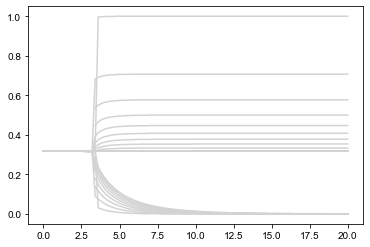

In [562]:
p = df.groupby(['n_1',  'group']).apply(lambda g: plt.plot(g.beta, g.s1, color = 'lightgrey', zorder = 1))
p = df.groupby(['n_1',  'group']).apply(lambda g: plt.plot(g.beta, g.s2, color = 'lightgrey', zorder = 1))
# plt.semilogy()

# Compute stability

In [584]:
def numerical_jacobian(n_1, s_1, s_2, n, beta):
    
    def h(s):
        s = make_s(s[0], s[1], n_1, n)
        gamma = compute_gamma(s, beta)
        G = np.tile(gamma, (n,1))
        v = (G.T - s.T.dot(G.T).dot(s)*np.eye(n)).dot(s)
        return(v[[0, -1]])
    
    J = np.zeros((2,2))
    eps = 10**(-8)
    J[0,:] = (h(np.array([s_1 + eps, s_2])) - h(np.array([s_1 - eps, s_2])))/(2*eps)
    J[1,:] = (h(np.array([s_1 , s_2 + eps])) - h(np.array([s_1 , s_2 - eps])))/(2*eps)
    return(J)

def test_stable(n_1, s_1, s_2, n, beta):
    J = numerical_jacobian(n_1, s_1, s_2, n, beta)
    try: 
        stable = np.linalg.eig(J)[0].max() < 0 
        return(stable)
    except np.linalg.LinAlgError:
        return(False)


In [585]:
df['stable'] = df.apply(lambda row: test_stable(row.n_1, row.s_1, row.s_2, n, row.beta), axis = 1)
# smoothing, needs some care
# df['stable'] = df.groupby(['n_1', 'group'])['stable'].transform(lambda g: g.max())

# idx = df.groupby(['beta'])['s1'].transform(max) == df['s1']
# df.stable[idx] = True

# df['stable']

# df['stable'] = df.eig < 1

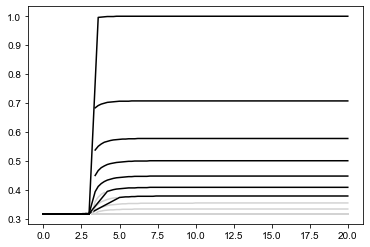

In [592]:
colors = ['lightgrey', 'black']
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = colors[int(g.stable.max())]))
# p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_2, zorder = 1, color = colors[int(g.stable.max())]))

# ix = df.s_1 > .9

# plt.plot(df.beta[ix], df.s_1[ix], zorder = 1, color = 'black')
# plt.plot(df.beta[ix], df.s_2[ix], zorder = 1, color = 'black')

In [595]:
test_stable(1, .2, .2, 10, 1)

True

In [598]:
df

,beta,n_1,s_1_0,s_2_0,n,s_1,s_2,s1,s2,group,stable
0,0.0,1,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
4,0.0,2,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
8,0.0,3,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
12,0.0,4,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
16,0.0,5,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
20,0.2,1,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
24,0.2,2,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
28,0.2,3,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
32,0.2,4,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
36,0.2,5,1.001,1.001,10,0.316,0.316,0.316,0.316,1.0,True
